# Part 3B: Curve Fitting and Covariance

Above we used the trick where we determine the parameters near the y-axis and then mutiply by the length of the "lever arm" out to the true intercept to provide a correlation between slope and true intercept for the purposes of uncertainty calculations. We could declare the correlation using a correlation matrix. The ```scipy.stats.linregress``` function does not return a covariance matrix but the ```scipy.optimize.curve_fit``` function will.

The ```curve_fit``` tool requires a function be declared to which it is to fit the data. We pass this function as well as the data into ```curve_fit``` and a list of fit parameters and a covariance matrix are returned. We can then create the uncertainty values using the covariance matrix and the coupling between slope and intercept will now be built into our ufloat values. 

The function can be changed so that a fit to a different model can be achieved with no other changes to the code. ```curve_fit``` is my personal favourite for data analysis. At least it was, until ```lmfit``` came into my life (more on that in the next notebook.) Consider the code below.

## Load the Toolbox

In a *Python* notebook, we can mix code and text. In the code block below are commands to load the libraries and modules we will need for this exercise. There are some special commands that are used to run unix xommands directly in the terminal of *Colab* to install *Python* packages that are not available by default. These can "commented out" if you run this notebook on your own computer. You will need to add the "hashtag" comment symbol. 

In [1]:
### Setup environment

!mkdir plots

### Install and load packages
 
!pip install uncertainties              # uncomment to install dependancy

from scipy.optimize import curve_fit     # tool for curve fitting
import scipy                             # includes tools for data analysis
import scipy.stats
import numpy as np                       # import the tools of NumPy 
from matplotlib import pyplot as plt     # tools for plotting

import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

### Set global variables

#location_data = "data/"         ## Use either local folder or github folder. 
#location_styles = "styles/"     ## Use github locations for Colab
location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"

size = [4,4]
size2 = [4,5]
size3 = [2.5,2.5]


mkdir: plots: File exists


## Perform Linear Curve Fit

The code below repeats the exact steps of the previous notebook but uses ```scipy.optimize.curve_fit``` to fit the linear Eyring plot. We will create the uncertain slope and intercept values using the covariance matrix returned from the curve fit function. Compare to the values that were produced from ```scipy.stats.linregress```. They are identical. Both functions used the least squares method and will give the same results. The curve fit function did not calculate the r-value and so I had to use a separate function from the ```scipy.stats``` module to do that.

In [2]:
### Experimental data
temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs = np.array(k_obs)

### Calculations for Erying plot axes
x = 1/temp
y = np.log(k_obs/temp)

###  Linear function to be used by curve_fit
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function            # popt is a list of the  parameters
popt, pcov = curve_fit(linear, x, y)  # pcov is the parameter covariance matrix

### Create new ufloat objects from returned parameters and covariance matrix.
### These ufloats will be properly connected by their covariance
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")



slope = -5560.07+/-249.08
intercept = 15.37+/-0.82
rsq = 0.994


### Calculate Thermodynamic Parameters

Now that the uncertainty values have been created using the covariance matrix from the ```scipy.optimize.curve_fit``` function we have an uncertain slope and intercept that are properly correlated. From this we can calculate uncertain values for $\Delta H^\ddagger$ and $\Delta S^\ddagger$ that propagate error correctly AND contain the information about their mutual correlation.

Observe that the rate calculated at a given temperature now has a correct confidence range.

In [3]:
### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(kobs)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")


The change in enthalpy is 46229.03+/-2070.94 kJ/mole
The change in entropy is -69.80+/-6.84 J/mole.K
15.31+/-0.29
Calculated k at T = 303 K is 15.31+/-0.29 s^-1


### Plot Curve Fit and Confidence Band

Using the properly correlated uncertain values for slope and intercept obtained from the curve fit we can plot the data, the best fit line and the confidence band. And never forget to plot the residuals as well. I have combined the three blocks of code above so that this single block could be copied and used as is.

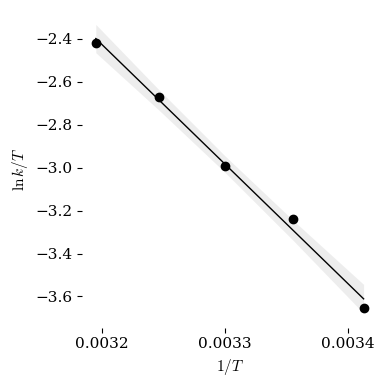

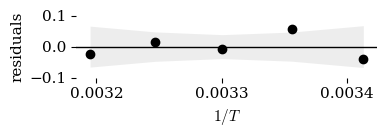

In [4]:
### calculate y-values using best fit parameters
#x_0 = np.linspace(0,np.max(x),100)      # for plotting from zero
x_0 = x                                  # using the data x values
best_fit_y = slope * x_0 + intercept     # uncertain array of line fit

### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                                # plot data with black circle
plt.plot(x_0,unp.nominal_values(best_fit_y),"k-") # plot fit line  from zero

#### Create Confidence band upper and lower bounds
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
plt.fill_between(x_0, fit_up, fit_dn, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth=0, label="confidence interval")
plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3B-01.pdf")
plt.show()                                       # show plot (and clear)

### Plot the residuals

# difference between data and line-fit
residuals = y - unp.nominal_values(best_fit_y)   
plt.figure(figsize=size).set_figheight(1.5)        # set plot height to 1 inch

dev = unp.std_devs(best_fit_y) * sigma
plt.fill_between(x_0, dev, -dev, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth=0, label="confidence interval")

plt.axhline(0, color='black')                  # plot a horizontal line
plt.plot(x,residuals,"ko")
plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.ylim(-.1,.1)
plt.xlabel(r"${1/T}$")
plt.ylabel(r"residuals")
plt.savefig("plots/3B-02.pdf")
plt.show()



## Using Experimental Error

Experimenatal values can be reported with data. We can include this in the curve fit. Points with greater error will have less weight in the curve fit. Observe the code below and note the one small change that included experimental error in the math of the `curve_fit` function. Also, look for the added plot command that added error bars to the plot. Otherwise its all the same.

The results changed slightly, reflecting the relative confidence in each data point.

slope = -5545.86+/-277.78
intercept = 15.31+/-0.92
rsq = 0.994
The change in enthalpy is 46110.87+/-2309.56 kJ/mole
The change in entropy is -70.24+/-7.63 J/mole.K
15.22+/-0.15
Calculated k at T = 303 K is 15.22+/-0.15 s^-1


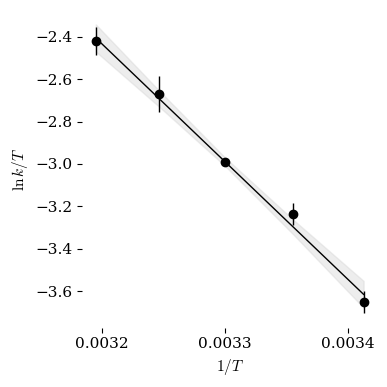

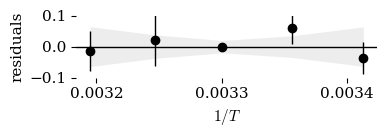

In [5]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function           
popt, pcov = curve_fit(linear, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)

print(kobs)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots
######################

### calculate y-values using best fit parameters
#x_0 = np.linspace(0,np.max(x),100)              # for plotting from zero
x_0 = x                                          # using the data x values
best_fit_y = slope * x_0 + intercept     # uncertain array of line fit

### Plot data and line-fit
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                                # plot data with black circle
plt.plot(x_0,unp.nominal_values(best_fit_y),"k-") # plot fit line from zero

#### Create Confidence band upper and lower bounds
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
plt.fill_between(x_0, fit_up, fit_dn, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")

plt.errorbar(x, y, yerr=y_err * sigma, xerr=None, 
             fmt="None", ecolor="black", zorder=1)


plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3B-03.pdf")
plt.show()                                       # show plot (and clear)


### Plot the residuals

# difference between data and line-fit
residuals = y - unp.nominal_values(best_fit_y)   
plt.figure().set_figheight(1.5)                    # set plot height to 1 inch

dev = unp.std_devs(best_fit_y) * sigma
plt.fill_between(x_0, dev, -dev, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   linewidth=0, label="confidence interval")

plt.errorbar(x, residuals, yerr=y_err * sigma, xerr=None, 
             fmt="None", ecolor="black", zorder=1)
plt.axhline(0, color='black')                  # plot a horizontal line
plt.plot(x,residuals,"ko")
plt.xticks([0.0032,0.0033,0.0034])         # there were too many x labels
plt.ylim(-.1,.1)
plt.xlabel(r"${1/T}$")
plt.ylabel(r"residuals")
plt.savefig("plots/3B-04.pdf")
plt.show()



## Get Bent

We have used the ```scipy.optimize.curve_fit``` function to fit an arbitrary model (in this case a linear function) taking into account experimental error. The uncertainties tools handled the error propagation in making the Erying plot and also allowed the creation of properly correlated fit parameters using the parameter list and the covarienace matrix returns by the curve fit function.

Many people feel that linearization of a function is a relic of a bygone error when graph paper reigned supreme. Let us fit the Erying equation directly by ploting rate constants vs temperature. Let us adapt the code above to plot $k_{cat}$ vs $T$ and fit this directly to the curved Erying equation...

$$ k = \frac{\kappa k_B}{h} T e^{\frac{-\Delta H^\ddagger}{RT}}e^{\frac{\Delta S^\ddagger}{R}}$$

... to obtain $\Delta H^\ddagger$ and $\Delta S^\ddagger$ direcly from the curve fit.

As you will see, we do not get any improvement in the quality fo the calculated thermodynamic values. This is because the linearization did not cause any large changes in the covarience between $x$ and $y$ (unlike the Michaelis-Menten plot vs. the linear Lineweaver-Burke plot, where linearization is a statistical nightmare.) 

Below is code that will accomplish a non-linear curve fit of the Eyring equation.

rsq = 0.983
The change in enthalpy is 46263.77+/-2236.64 kJ/mole
The change in entropy is -69.74+/-7.39 J/mole.K
Calculated k at T = 303 K is 15.22+/-0.15 s^-1


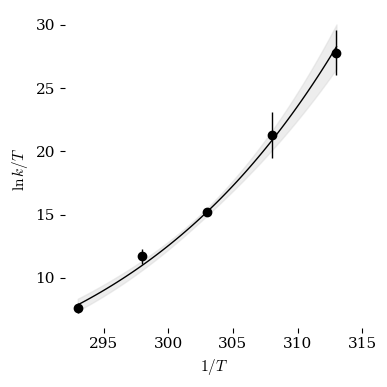

<Figure size 400x400 with 0 Axes>

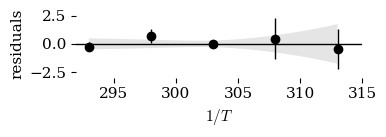

In [6]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

x = temp
y = unp.nominal_values(k_obs_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(k_obs_u)   # because curve_fit can handle ufloats

######################
###  Function to be used by curve_fit
######################
def eyring(T, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)
    return y

def eyring_u(T, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
    return y

######################
### Use curve_fit function           
######################
popt, pcov = curve_fit(eyring, x, y, 
                       sigma = y_err   # use exp error
                       )  

### Create new ufloat objects from returned parameters and covariance matrix.
### These ufloats will be properly connected by their covariance
(dH, dS) = un.correlated_values(popt, pcov)

######################
### REPORT
######################
r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots
######################
plt.rcdefaults()
plt.style.use(location_styles + "tufte.mplstyle")
plt.figure(figsize=size)

plt.plot(x,y,"ko")                                # plot data with black circle

### calculate y-values using best fit parameters
#x_0 = np.linspace(1,np.max(x),100)              # for plotting from zero
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = eyring_u(x_0, dH, dS)     # uncertain array of line fit

### Plot line-fit
plt.plot(x_0,unp.nominal_values(best_fit_y),"k-") # plot fit line from zero

######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
plt.fill_between(x_0, fit_up, fit_dn, 
                   color="lightgray", alpha=0.4, zorder = 0,
                   label="confidence interval")

plt.errorbar(x, y, yerr=y_err * sigma, xerr=None, 
             fmt="None", ecolor="black", zorder=2)
plt.xticks([295,300, 305,310,315])         # there were too many x labels
plt.xlabel(r"${1/T}$")
plt.ylabel(r"$\ln{k/T}$")
plt.savefig("plots/3B-05.pdf")
plt.show()                                       # show plot (and clear)

######################
### Plot the residuals
######################
residuals = y - eyring(x, dH.n, dS.n)    # difference between data and line-fit
plt.figure(figsize=size)
plt.figure().set_figheight(1.5)          # set plot height to 1 inch

# make filled band
plt.fill_between(x_0, unp.std_devs(best_fit_y) * sigma, -unp.std_devs(best_fit_y) * sigma, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")


plt.errorbar(x, residuals, yerr=y_err * sigma, xerr=None, 
             fmt="None", ecolor="black", zorder=2)
plt.axhline(0, color='black')        # plot a horizontal line
plt.plot(x,residuals,"ko")
plt.xticks([295,300, 305,310,315])       # there were too many x labels
plt.ylim(-3,3)

plt.xlabel(r"${1/T}$")
plt.ylabel(r"residuals")
plt.savefig("plots/3B-06.pdf")
plt.show()

## Get Fancy

The code below is the same as in the section above except for the plotting. I have used a more flexible set of tools from the ```matplotlib.pyplot``` library to create a more styled plot. Below that are plotting code that present the plot and the residuals separately.

### Plot of $k$ vs $T$ with Residuals

rsq = 0.983
The change in enthalpy is 46263.77+/-2236.64 kJ/mole
The change in entropy is -69.74+/-7.39 J/mole.K
Calculated k at T = 303 K is 15.22+/-0.15 s^-1


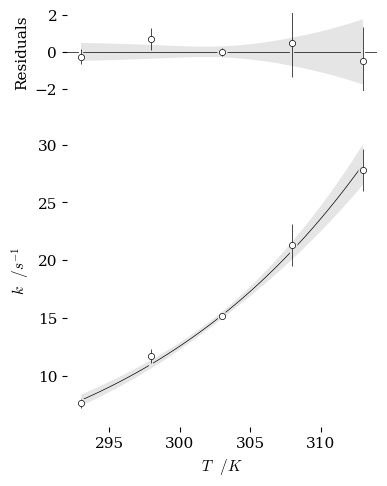

In [7]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

x = temp
y = unp.nominal_values(k_obs_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(k_obs_u)   # because curve_fit can handle ufloats

######################
###  Function to be used by curve_fit
######################
def eyring(T, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)
    return y

def eyring_u(T, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
    return y

######################
### Use curve_fit function           
######################
popt, pcov = curve_fit(eyring, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(dH, dS) = un.correlated_values(popt, pcov)

######################
### REPORT
######################
r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$k$  $/s^{-1}$", 
          xlabel=r"$T$  $/K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
#x_0 = np.linspace(1,np.max(x),100)              # for plotting from zero
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = eyring_u(x_0, dH, dS)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   linewidth = 0, label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma*2, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

#plt.show()                                       # show plot (and clear)

######################
### Plot the residuals
######################
residuals = y - eyring(x, dH.n, dS.n)    # difference between data and line-fit
residuals_u = y - eyring_u(x, dH, dS) 

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) * sigma, -unp.std_devs(best_fit_y) * sigma, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0)          
ax[0].set_xticks([])

### Output plot
plt.tight_layout()
plt.savefig("plots/3B-07.pdf")

plt.show()


### Plot of $k$ vs $T$

rsq = 0.983
The change in enthalpy is 46263.77+/-2236.64 kJ/mole
The change in entropy is -69.74+/-7.39 J/mole.K
Calculated k at T = 310 K is 23.57+/-0.55 s^-1


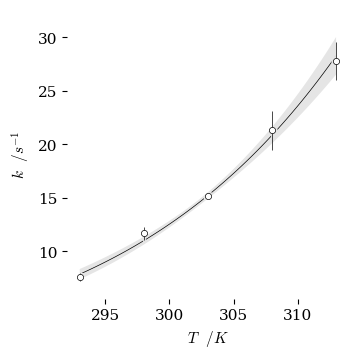

In [8]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

x = temp
y = unp.nominal_values(k_obs_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(k_obs_u)   # because curve_fit can handle ufloats

######################
###  Function to be used by curve_fit
######################
def eyring(T, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)
    return y

def eyring_u(T, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
    return y

######################
### Use curve_fit function           
######################
popt, pcov = curve_fit(eyring, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix
(dH, dS) = un.correlated_values(popt, pcov)

######################
### REPORT
######################
r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)  

# Settings for plot
ax.set(
#          title = Title,       
          ylabel=r"$k$  $/s^{-1}$", 
          xlabel=r"$T$  $/K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

ax.scatter(x, y, marker = "o", s = 40, color = "white", zorder = 1)
ax.scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

### calculate y-values using best fit parameters
#x_0 = np.linspace(1,np.max(x),100)              # for plotting from zero
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = eyring_u(x_0, dH, dS)     # uncertain array of line fit

# Plot the curve fit line
ax.plot(x_0,unp.nominal_values(best_fit_y), 
        marker = None, color = "black", 
        linewidth=0.5, zorder = 0)

######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax.fill_between(x_0, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
ax.errorbar(x, y, yerr=y_err*sigma*2, xerr=None, fmt="None", 
               ecolor="white", elinewidth=2, zorder=1)

ax.errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3B-08.pdf")
plt.show()


### Plot of Residuals

This plot is styled to fit in the side bar of my handouts.

rsq = 0.983
The change in enthalpy is 46263.77+/-2236.64 kJ/mole
The change in entropy is -69.74+/-7.39 J/mole.K
Calculated k at T = 303 K is 15.22+/-0.15 s^-1


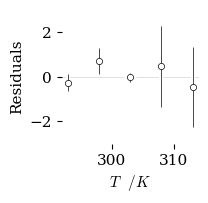

In [9]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

x = temp
y = unp.nominal_values(k_obs_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(k_obs_u)   # because curve_fit can handle ufloats

######################
###  Function to be used by curve_fit
######################
def eyring(T, dH, dS):       # function for curve fit. No uncertainty allowed
    
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * np.exp(-dH/(R*T)) * np.exp(dS/R)
    return y

def eyring_u(T, dH, dS):     # same function as above but uses uncertainty
                             # to be used when calculating confidence bands.
    R = scipy.constants.R
    kb = scipy.constants.k
    h = scipy.constants.h
    kappa = 1

    y = (kappa * kb / h) * T * unp.exp(-dH/(R*T)) * unp.exp(dS/R)
    return y

######################
### Use curve_fit function           
######################
popt, pcov = curve_fit(eyring, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(dH, dS) = un.correlated_values(popt, pcov)

######################
### REPORT
######################
r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 303
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size3 = [2.5,2.5]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size3)  


######################
### Plot the residuals
######################

ax.set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"$T$  $/K$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-3,3]
       )

residuals = y - eyring(x, dH.n, dS.n)   # difference between data and line-fit
### White background Graphics
ax.scatter(x, residuals, marker = "o", s = 60, color = "white", zorder = 1)
ax.errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax.scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax.errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=2)

ax.axhline(0, color='lightgray', linewidth=0.5, zorder=0) 
#ax.set_xticks([])

#plt.show()

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3B-09.pdf")
plt.show()


### Erying Plot of $\ln k/T$ vs $1/T$ with Residuals

slope = -5545.86+/-277.78
intercept = 15.31+/-0.92
rsq = 0.994
The change in enthalpy is 46110.87+/-2309.56 kJ/mole
The change in entropy is -70.24+/-7.63 J/mole.K
Calculated k at T = 310 K is 23.55+/-0.56 s^-1


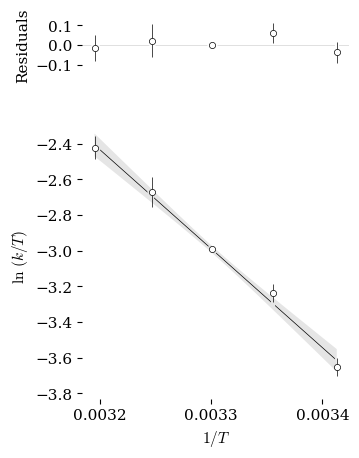

In [10]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function           
popt, pcov = curve_fit(linear, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\ln\,\left(k/T\right)$ ", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
#x_0 = np.linspace(1,np.max(x),100)              # for plotting from zero
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = linear(x_0, slope, intercept)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma*2, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([0.0032,0.0033,0.0034])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - linear(x, slope.n, intercept.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)
### Other elements
ax[0].axhline(0, color='lightgray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3B-10.pdf")
plt.show()


### Erying Plot of $\ln k/T$ vs $1/T$ without Residuals

slope = -5545.86+/-277.78
intercept = 15.31+/-0.92
rsq = 0.994
The change in enthalpy is 46110.87+/-2309.56 kJ/mole
The change in entropy is -70.24+/-7.63 J/mole.K
Calculated k at T = 310 K is 23.55+/-0.56 s^-1


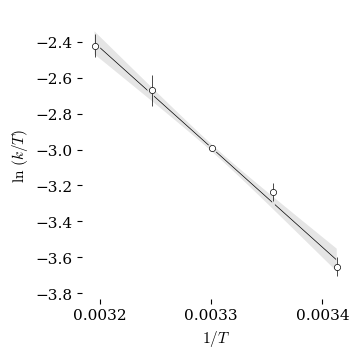

In [11]:
######################
### Experimental data with error
######################

temp = [293, 298, 303, 308, 313]       # list of temperatures
k_obs = [7.6, 11.7, 15.2, 21.3, 27.8]  # list of observe rate constants (s^-1)
k_obs_err= [0.2 , 0.3, 0.1, 0.9, 0.9]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function           
popt, pcov = curve_fit(linear, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)  

# Settings for plot
ax.set(
#          title = Title,       
          ylabel=r"$\ln\,\left(k/T\right)$ ", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

ax.scatter(x, y, marker = "o", s = 40, color = "white", zorder = 1)
ax.scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

### calculate y-values using best fit parameters
#x_0 = np.linspace(1,np.max(x),100)              # for plotting from zero
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = linear(x_0, slope, intercept)     # uncertain array of line fit

# Plot the curve fit line
ax.plot(x_0,unp.nominal_values(best_fit_y), 
        marker = None, color = "black", 
        linewidth=0.5, zorder = 0)

######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax.fill_between(x_0, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
ax.errorbar(x, y, yerr=y_err*sigma*2, xerr=None, fmt="None", 
               ecolor="white", elinewidth=2, zorder=1)

ax.errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)
ax.set_xticks([0.0032,0.0033,0.0034])

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3B-11.pdf")
plt.show()


### Erying Plot of Residuals Only

slope = -5545.86+/-277.78
intercept = 15.31+/-0.92
rsq = 0.994
The change in enthalpy is 46110.87+/-2309.56 kJ/mole
The change in entropy is -70.24+/-7.63 J/mole.K
Calculated k at T = 310 K is 23.55+/-0.56 s^-1


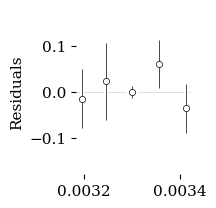

In [12]:
######################
### Experimental data with error
######################


### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function           
popt, pcov = curve_fit(linear, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

size3 = [2.5,2.5]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size3)  


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - linear(x, slope.n, intercept.n)     

ax.set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-.18,0.18]
       )

### White background Graphics
ax.scatter(x, residuals, marker = "o", s = 60, color = "white", zorder = 1)
ax.errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax.scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax.errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=2)

ax.axhline(0, color='lightgray', linewidth=0.5, zorder=0)
#ax.set_xticks([])

#plt.show()

### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3B-12.pdf")
plt.show()
